Here I give an example of calculating the band basis mass enhancement. In this example I use a fully charge self consistent DFT+DMFT calculation on NdNiO$_2$ with Wien2k and Triqs dft_tools. 

In this case, I already have a converged fully charge self consistent DFT+DMFT calculation with all five Ni-3d orbitals treated as correlated, a projection window from -10 to 10 eV, a rotationally invariant slater Hamiltonian with U = 7 eV and J = 0.7 eV, and an FLL double counting correction. After convergence I used dmftproj to calculate the projectors along a high symmetry $k$ point path

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from h5 import HDFArchive
from triqs.gf import *

In this case, there are 250 k points, 1 correlated shell, 1 unique spin, 5 correlated orbitals, and 21 bands. Therefore, the projection matrices "proj_mat"

In [9]:
with HDFArchive('NdNiO2_fcsc_bands_proj.h5', 'r') as A: #file containing projection matrices for band k path
    proj_mat = A['proj_mat']
proj_mat.shape


(250, 1, 1, 5, 21)

In [10]:
proj = proj_mat[:,0,0,:,:]

with HDFArchive('NdNiO2_fcsc_Sigma.h5','r') as A:
    Sigma = A['Sigma_iw'] #self eneregy in BlockGf form
    dc = A['dc'] #double counting energy
    mu = A['mu'] #chemical potential

sorb = np.zeros((7,5,5), dtype = np.complex_) #orbital basis self energy matrix for first 7 matsubara points

for i in range(5):
    sorb[:,i,i] = Sigma['up_%d'%i].data[1025:1032,0,0]
omega = [i.imag for i in Sigma.mesh][1025:1032] #matsubara frequencies
nband = proj.shape[-1]
nk = proj.shape[0]
sband = np.einsum('kij,wil,klm->kwjm', proj.conj(), sorb, proj) #use projectors to upfold impurity self energy to band basis

#for each band, find the mass enhancement by fitting a polynomial to the first 7 matsubara points and taking the linear term
# as the derivative at 0
Zs = np.ones((nk, nband)) #mass enhancements
npoints = 7
order = 4
for k in range(nk):
    for i in range(nband):
        lt = np.polyfit(omega[:npoints], sband[k,:npoints, i, i].imag, order)[-2]
        Zs[k, i] = 1 - lt


Now I plot the Wien2k DFT bands with the pseudocolor showing the mass enhacement of the bands

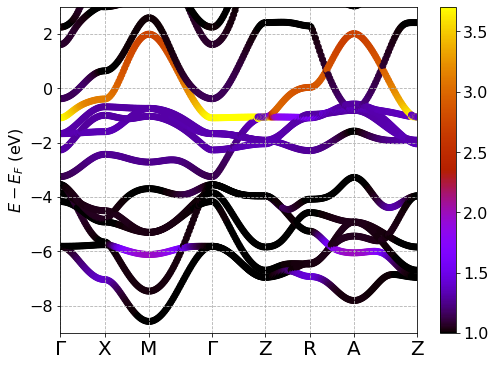

In [13]:
plt.figure(figsize=(8, 6))
plt.rc('font', size=16)
bands = np.loadtxt('NdNiO2_wien2k_bands.dat')[:, 10:(10+nband)]
ks = range(nk)
kp = []
for k in ks:
    for i in range(nband):
        kp.append(k)     
E = bands.reshape(nk*nband)
plt.scatter(kp, E, c =  Zs.reshape(nk*nband), cmap = 'gnuplot')
plt.xlim(0,249)
plt.ylim(-9,3) 
plt.grid(ls = '--')
plt.ylabel('$E - E_F$ (eV)')
plt.xticks([0,31, 62, 106, 143, 174, 205, 249], ['$\Gamma$', 'X', 'M', '$\Gamma$', 'Z', 'R', 'A', 'Z'], fontsize = 20)
plt.colorbar()
plt.show()

In this case, the mass enhancement is dominated by the Ni-$d_{x^2-y^2}$ derived band that crosses the Fermi level